In [21]:
import pandas as pd

psi = pd.read_csv("../../data_samples/quantum.csv")['psi'].values

import torch
from torch import nn

class Hnet(nn.Module):
	def __init__(self, z_dim=2, model="kepler_2d"):
		super(Hnet, self).__init__()
		self.z_dim = z_dim
		# Just for polynomial features
		if model == "quantum":
			input_dim = int(z_dim/2)
		else:
			input_dim = z_dim
		self.model = model
		
		if model == "harmonic_2d_aniso" or model == "harmonic_2d_iso" or model == "KdV_1d" or model == "quantum":
			#input_dim or z_dim
			self.h_lin_1 = nn.Linear(input_dim, 400) #
			self.h_lin_2 = nn.Linear(400, 400) #
			self.h_lin_3 = nn.Linear(400, 1) #
			self.h_relu = nn.ReLU()
			self.h_tanh = nn.Tanh()
			self.h_silu = nn.SiLU()
			
		elif model == "kepler_2d":
			self.h_lin_1 = nn.Linear(4, 400) #
			self.h_lin_2 = nn.Linear(400, 400) #
			self.h_lin_3 = nn.Linear(400, 1) #
			self.h_relu = nn.ReLU()
			self.h_tanh = nn.Tanh()
			self.h_silu = nn.SiLU()
			
			self.v_lin_1 = nn.Linear(1, 128) #
			self.v_lin_2 = nn.Linear(128, 128) #
			self.v_lin_3 = nn.Linear(128, 1) #
			self.v_relu = nn.ReLU()
			self.v_tanh = nn.Tanh()
			self.v_silu = nn.SiLU()
			
		elif model == "threebody_2d":
			self.h_lin_1 = nn.Linear(4, 400) #
			self.h_lin_2 = nn.Linear(400, 400) #
			self.h_lin_3 = nn.Linear(400, 1) #
			self.h_relu = nn.ReLU()
			self.h_tanh = nn.Tanh()
			self.h_silu = nn.SiLU()
			
			self.v_lin_1 = nn.Linear(1, 128) #
			self.v_lin_2 = nn.Linear(128, 128) #
			self.v_lin_3 = nn.Linear(128, 1) #
			self.v_relu = nn.ReLU()
			self.v_tanh = nn.Tanh()
			self.v_silu = nn.SiLU()
			
		else:
			print("model not recognized!")
			
	
	def h_z_basic(self, z):
		out = self.h_lin_1(z)
		# debugging, only allows linear regression
		out = self.h_silu(out)
		out = self.h_lin_2(out)
		out = self.h_silu(out)
		out = self.h_lin_3(out)
		return out
			
		
	
	def h_z(self, z):
	
		if self.model == "harmonic_2d_aniso" or self.model == "harmonic_2d_iso" or self.model == "KdV_1d" or self.model=="quantum":
			
			if self.model == "KdV_1d":
				#print(z.shape, self.z_dim)
				#assert(z.shape[2]==self.z_dim)
				bs = z.shape[0]
				num_pts = z.shape[1]
				z = z.reshape(bs*num_pts,self.z_dim)
				if self.z_dim == 2:
					z_0 = z[:,0]
					z_1 = torch.abs(z[:,1])
					z = torch.transpose(torch.stack([z_0, z_1]),0,1)
				if self.z_dim == 3:
					z_0 = z[:,0]
					z_1 = torch.abs(z[:,1])
					z_2 = torch.abs(z[:,2])
					z = torch.transpose(torch.stack([z_0, z_1, z_2]),0,1)
                    
			if self.model == "quantum":
				bs = z.shape[0]
				num_pts = z.shape[1]
				z = z.reshape(bs*num_pts,self.z_dim)
				if self.z_dim == 2:
					z_0 = torch.sqrt(z[:,0]**2+z[:,1]**2)                  
					z = torch.transpose(torch.stack([z_0]),0,1)
				if self.z_dim == 4:
					z_0 = torch.sqrt(z[:,0]**2+z[:,1]**2)
					z_1 = torch.sqrt(z[:,2]**2+z[:,3]**2)   
					z = torch.transpose(torch.stack([z_0, z_1]),0,1)
				if self.z_dim == 6:
					z_0 = torch.sqrt(z[:,0]**2+z[:,1]**2)
					z_1 = torch.sqrt(z[:,2]**2+z[:,3]**2)   
					z_2 = torch.sqrt(z[:,2]**2+z[:,3]**2)                       
					z = torch.transpose(torch.stack([z_0, z_1, z_2]),0,1)
		
			out = self.h_z_basic(z)
			
			if self.model == "KdV_1d" or self.model == "quantum":
				#print("haha")
				out = out.reshape(bs, num_pts, 1)
				out = torch.mean(out, dim=1)
			#print(out.shape)
			
		elif self.model == "kepler_2d":
			def K(z_):
				out = self.h_lin_1(z_)
				out = self.h_silu(out)
				out = self.h_lin_2(out)
				out = self.h_silu(out)
				k = self.h_lin_3(out)
				return k
			
			def V(z_):
				out = self.v_lin_1(z_)
				out = self.v_silu(out)
				out = self.v_lin_2(out)
				out = self.v_silu(out)
				v = self.v_lin_3(out)
				return v
				
			r = torch.sqrt(z[:,0]**2+z[:,2]**2).unsqueeze(dim=1)
			
			Ksum = K(z)
			Vsum = V(r)
			out = Ksum + Vsum
			#print(out.shape)

			
		elif self.model == "threebody_2d":
		
			def K(z_):
				out = self.h_lin_1(z_)
				out = self.h_silu(out)
				out = self.h_lin_2(out)
				out = self.h_silu(out)
				k = self.h_lin_3(out)
				return k
			
			def V(z_):
				out = self.v_lin_1(z_)
				out = self.v_silu(out)
				out = self.v_lin_2(out)
				out = self.v_silu(out)
				v = self.v_lin_3(out)
				return v
				
			r12 = torch.sqrt((z[:,0]-z[:,4])**2+(z[:,1]-z[:,5])**2).unsqueeze(dim=1)
			r13 = torch.sqrt((z[:,0]-z[:,8])**2+(z[:,1]-z[:,9])**2).unsqueeze(dim=1)
			r23 = torch.sqrt((z[:,4]-z[:,8])**2+(z[:,5]-z[:,9])**2).unsqueeze(dim=1)
			
			Ksum = K(z[:,:4]) + K(z[:,4:8]) + K(z[:,8:])
			Vsum = V(r12) + V(r13) + V(r23)
			out = Ksum + Vsum

		return out

	def forward(self, z, verbose=False):
		#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
		bs = z.shape[0]

		h = self.h_z(z)
		dh = torch.autograd.grad(h, z, torch.ones_like(h), create_graph=True, retain_graph=True)[0]
		bs = z.shape[0]
		'''if self.model == "quantum":
			M = torch.ones(bs,).unsqueeze(dim=1).unsqueeze(dim=2) * self.M.unsqueeze(dim=0)
			dh_t = torch.matmul(dh, M)
			dh_t = dh.reshape(bs,-1)
			dh = dh.reshape(bs,-1)
			return dh, dh_t
		else:'''
		dh = dh.reshape(bs,-1)
		return dh

In [22]:
H1 = Hnet(z_dim=1, model="KdV_1d")
H1.load_state_dict(torch.load("../quantum/seed_experiments/0.pt"))

H2 = Hnet(z_dim=1, model="KdV_1d")
H2.load_state_dict(torch.load("../quantum/seed_experiments/1.pt"))

H3 = Hnet(z_dim=1, model="KdV_1d")
H3.load_state_dict(torch.load("../quantum/seed_experiments/2.pt"))

H4 = Hnet(z_dim=1, model="KdV_1d")
H4.load_state_dict(torch.load("../quantum/seed_experiments/3.pt"))

H5 = Hnet(z_dim=1, model="KdV_1d")
H5.load_state_dict(torch.load("../quantum/seed_experiments/4.pt"))

<All keys matched successfully>

In [23]:
psi = torch.tensor(psi.reshape(1000,40,2), dtype=torch.float, requires_grad=True)
psi = torch.norm(psi, dim=2, keepdim=True)
h1 = H1.h_z_basic(psi)
h2 = H2.h_z_basic(psi)
h3 = H3.h_z_basic(psi)
h4 = H4.h_z_basic(psi)
h5 = H5.h_z_basic(psi)

In [24]:
psi = psi.detach().numpy().reshape(40000,1)
h1 = h1.detach().numpy().reshape(-1)
h2 = h2.detach().numpy().reshape(-1)
h3 = h3.detach().numpy().reshape(-1)
h4 = h4.detach().numpy().reshape(-1)
h5 = h5.detach().numpy().reshape(-1)

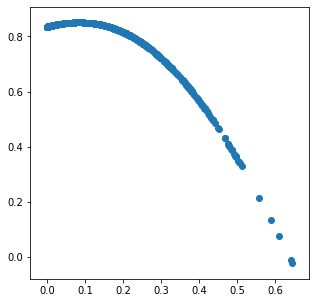

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))

plt.scatter(psi[:1000,0], h5[:1000])


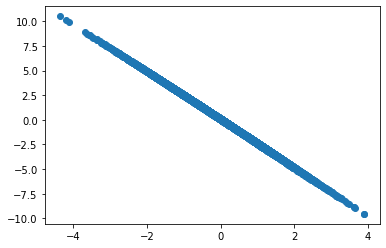

In [59]:
plt.scatter(x0+0.6*x1, h1)

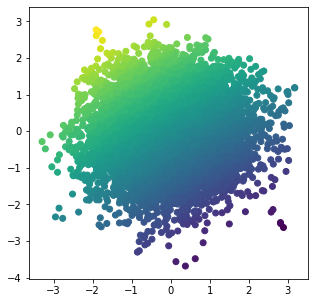

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))

plt.scatter(psi[:,0], psi[:,1], c=h3)
x0 = psi[:,0]
x1 = psi[:,1]

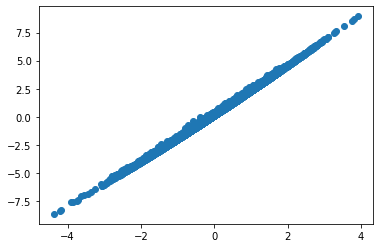

In [73]:
plt.scatter(-0.6*x0+x1, h3)